# Librerias

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns

# Lectura de datos

In [4]:
# Cargar el archivo .nc utilizando xarray
data_boyaca = xr.open_dataset('../data/data_boyaca_municipios.nc')
df_boyaca = data_boyaca.to_dataframe().reset_index()

# Leer el shapefile con los municipios de Boyacá
shape_boyaca_municipios = gpd.read_file('../shapes/shape_boyaca_municipios.shp')
df_shapefile_boyaca = pd.DataFrame(shape_boyaca_municipios)

# Seleccionar la variable de precipitación
precipitation = data_boyaca['precip']

# Formatos archivos

In [ ]:
# Verificar los nombres de las variables disponibles
print(data_boyaca)

# Muestra el formato
print('shapefile : ',shape_boyaca_municipios)

# Diagrama de cajas y bigotes mensual para la precipitación de cada municipio

In [7]:
import calendar

# Filtrar los datos para el año 2022
data_2022 = df_boyaca[df_boyaca['time'].dt.year == 2022]

# Obtener los datos de precipitación mensual para cada municipio
monthly_precipitation = data_2022['precip']

# Obtener la cantidad de municipios
num_municipios = len(shape_boyaca_municipios)

# Calcular el número de filas y columnas para los subplots
num_rows = (num_municipios - 1) // 7 + 1
num_cols = min(num_municipios, 7)

# Crear una figura y subplots para los municipios
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3*num_rows), sharex=True, sharey=True)
fig.suptitle('Precipitación mensual en los municipios de Boyacá - 2022', fontsize=16)

# Ordenar los municipios alfabéticamente
shape_boyaca_municipios_sorted = shape_boyaca_municipios.sort_values('municipio')

# Recorrer cada municipio del shapefile
for i, (municipio, polygon) in enumerate(shape_boyaca_municipios_sorted.iterrows()):
    # Calcular las coordenadas del subplot actual
    row = i // num_cols
    col = i % num_cols

    # Crear un subplot para el municipio actual
    ax = axes[row, col]

    # Crear un DataFrame con los datos de precipitación para el municipio actual
    polygon_data = monthly_precipitation.loc[monthly_precipitation['municipio'] == polygon.municipio]

    # Verificar si el DataFrame no está vacío
    if not polygon_data.empty:
        # Crear el diagrama de cajas y bigotes utilizando Seaborn
        sns.boxplot(data=polygon_data, x=polygon_data.index.month, y='precip', ax=ax)

        # Mostrar los valores de precipitación en los subplots
        sns.stripplot(data=polygon_data, x=polygon_data.index.month, y='precip', color='black', size=2, ax=ax)

        # Obtener los nombres de los meses
        month_names = [calendar.month_name[month] for month in range(1, 13)]

        # Configurar el eje x con los nombres de los meses
        ax.set_xticklabels(month_names)

        # Configurar los límites del eje y para una mejor visualización
        ax.set_ylim(bottom=0)

    # Configurar el título y etiquetas de los ejes
    ax.set_title(polygon.municipio)
    ax.set_xlabel('Mes')
    ax.set_ylabel('Precipitación (mm)')

# Ajustar los espacios entre los subplots
plt.tight_layout()

# Agregar una leyenda general para los subplots
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

# Mostrar la figura
plt.show()


KeyError: 'municipio'

Error in callback <function flush_figures at 0x000001E08B66F520> (for post_execute):


KeyboardInterrupt: 

# Tratamiento de datos anomalos

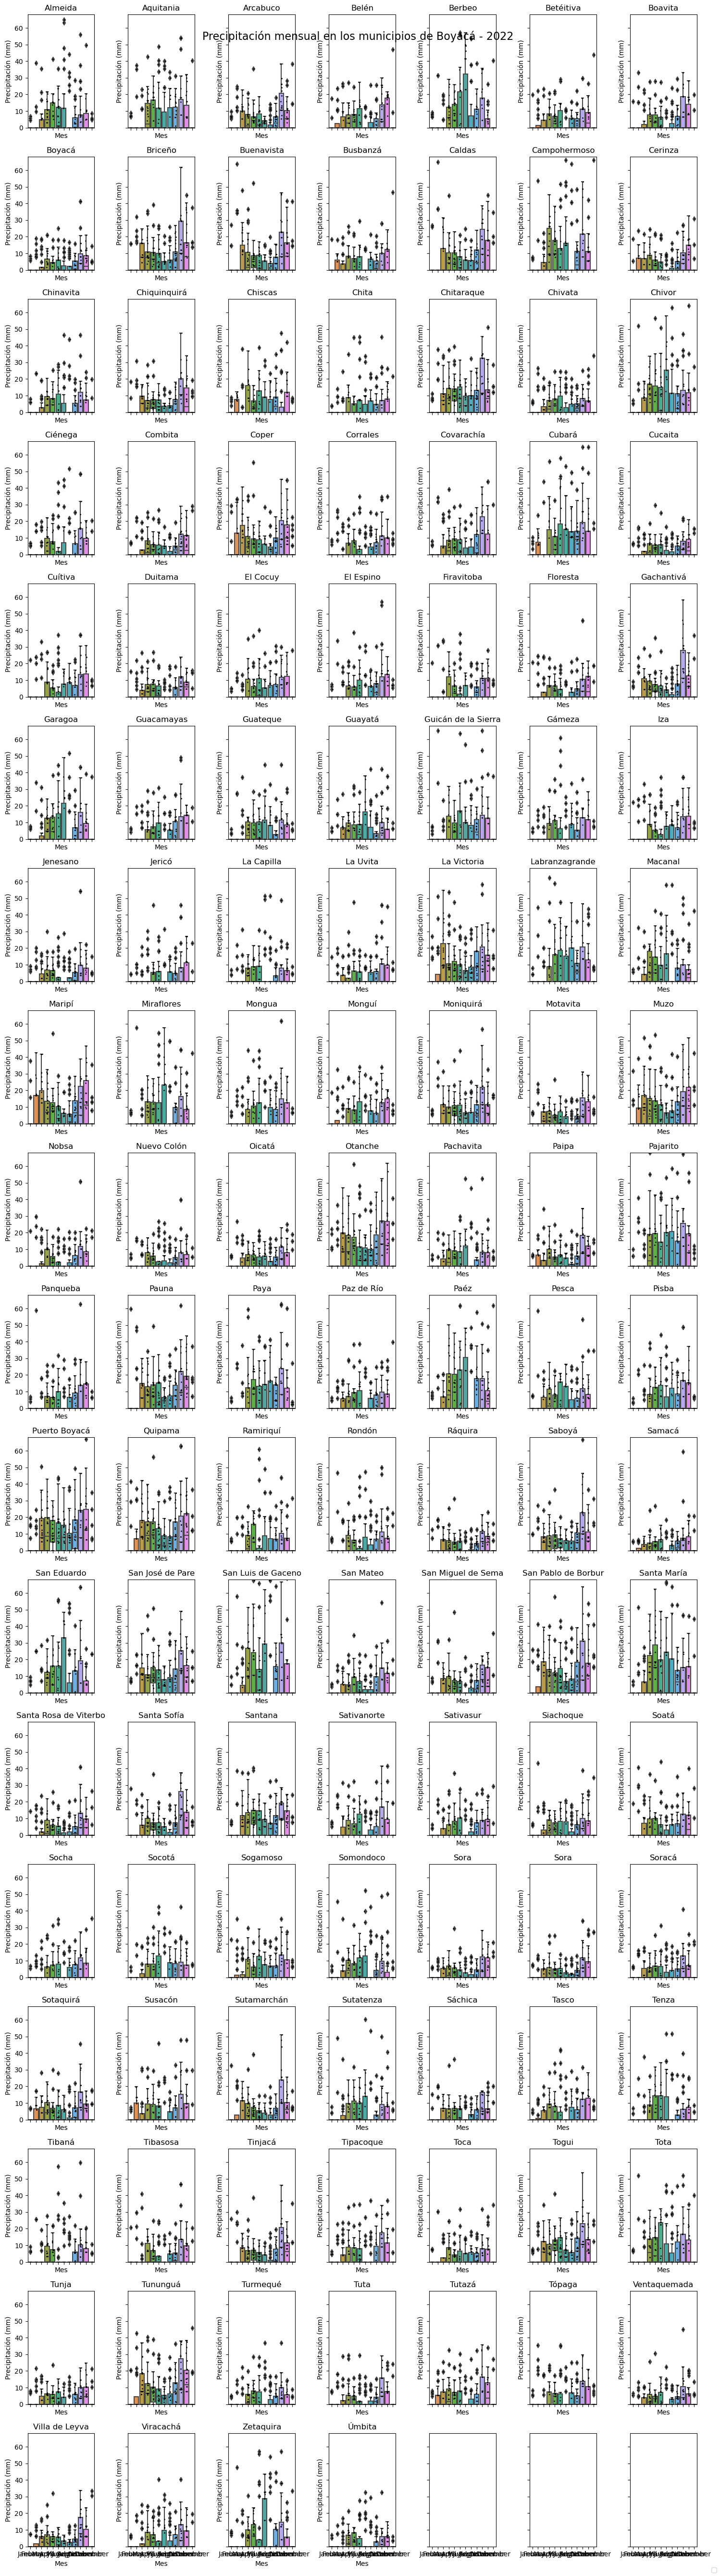

In [4]:
import calendar
import seaborn as sns
import numpy as np

from scipy.stats.mstats import winsorize

# Filtrar los datos para el año 2022
data_2022 = data_boyaca.sel(time=slice('2022-01-01', '2022-12-31'))

# Obtener los datos de precipitación mensual para cada municipio
monthly_precipitation = data_2022['precip']

# Obtener la cantidad de municipios
num_municipios = len(shape_boyaca_municipios)

# Calcular el número de filas y columnas para los subplots
num_rows = (num_municipios - 1) // 7 + 1
num_cols = min(num_municipios, 7)

# Crear una figura y subplots para los municipios
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3*num_rows), sharex=True, sharey=True)
fig.suptitle('Precipitación mensual en los municipios de Boyacá - 2022', fontsize=16)

# Ordenar los municipios alfabéticamente
shape_boyaca_municipios_sorted = shape_boyaca_municipios.sort_values('municipio')

# Recorrer cada municipio del shapefile
for i, (municipio, polygon) in enumerate(shape_boyaca_municipios_sorted.iterrows()):
    # Calcular las coordenadas del subplot actual
    row = i // num_cols
    col = i % num_cols

    # Crear un subplot para el municipio actual
    ax = axes[row, col]

    # Crear un DataFrame con los datos de precipitación para el municipio actual
    polygon_data = monthly_precipitation.sel(
        latitude=polygon.geometry.centroid.y,
        longitude=polygon.geometry.centroid.x,
        method='nearest'
    ).to_dataframe()

    # Verificar si el DataFrame no está vacío
    if not polygon_data.empty:
        # Calcular la desviación estándar
        std_dev = polygon_data['precip'].std()

        # Identificar los valores anómalos
        is_outlier = np.abs(polygon_data['precip'] - polygon_data['precip'].mean()) > 2 * std_dev

        # Winsorizar los valores anómalos
        polygon_data.loc[is_outlier, 'precip'] = winsorize(polygon_data.loc[is_outlier, 'precip'], limits=[0.05, 0.05])


        # Crear el diagrama de cajas y bigotes utilizando Seaborn
        sns.boxplot(data=polygon_data, x=polygon_data.index.month, y='precip', ax=ax)

        # Mostrar los valores de precipitación en los subplots
        sns.stripplot(data=polygon_data, x=polygon_data.index.month, y='precip', color='black', size=2, ax=ax)

        # Obtener los nombres de los meses
        month_names = [calendar.month_name[month] for month in range(1, 13)]

        # Configurar el eje x con los nombres de los meses
        ax.set_xticklabels(month_names)

        # Configurar los límites del eje y para una mejor visualización
        ax.set_ylim(bottom=0)

    # Configurar el título y etiquetas de los ejes
    ax.set_title(polygon.municipio)
    ax.set_xlabel('Mes')
    ax.set_ylabel('Precipitación (mm)')

# Ajustar los espacios entre los subplots
plt.tight_layout()

# Agregar una leyenda general para los subplots
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower right')

# Mostrar la figura
plt.show()


# Mapa de calor del promedio de la precipitación mensual para cada año

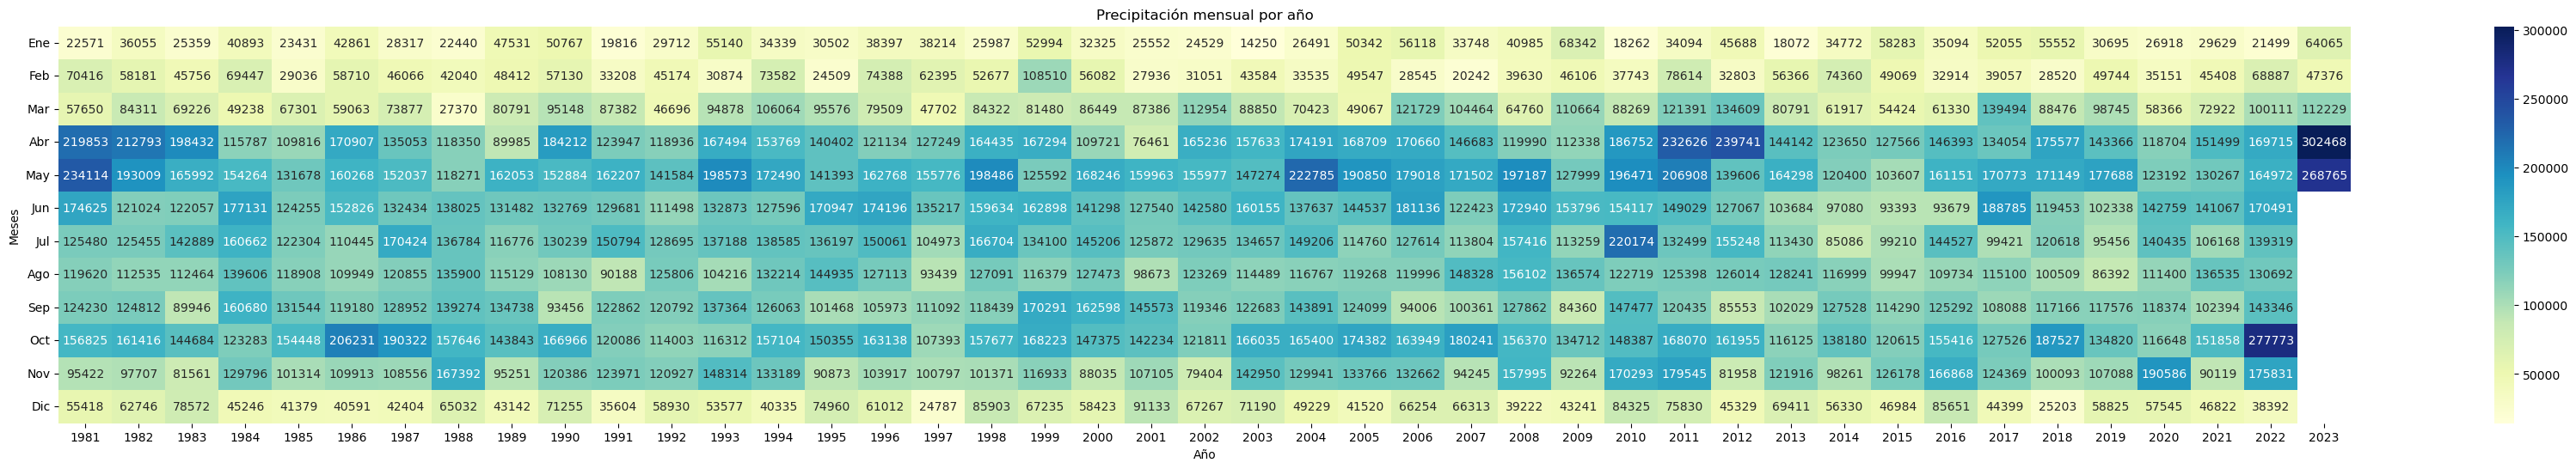

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_boyaca['time'] = pd.to_datetime(df_boyaca['time'])
df_boyaca['year'] = df_boyaca['time'].dt.year
df_boyaca['month'] = df_boyaca['time'].dt.month
df_boyaca['day'] = df_boyaca['time'].dt.day

# Obtener la precipitación mensual por año
monthly_precipitation_per_year = df_boyaca.groupby(['year','month'])['precip'].sum().reset_index()

# Rellenar los meses faltantes con valores nulos
monthly_precipitation_per_year = monthly_precipitation_per_year.pivot_table(index='month', columns='year', values='precip')

# Crear el mapa de calor
plt.figure(figsize=(43, 6))

sns.heatmap(monthly_precipitation_per_year, cmap='YlGnBu', cbar=True, annot=True, fmt=".0f")

# Configurar los ejes y etiquetas
plt.xlabel('Año')
plt.ylabel('Meses')
plt.title('Precipitación mensual por año')
plt.yticks(np.arange(12)+0.5, ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'], rotation=0, fontsize=10)

# Mostrar la figura
plt.show()

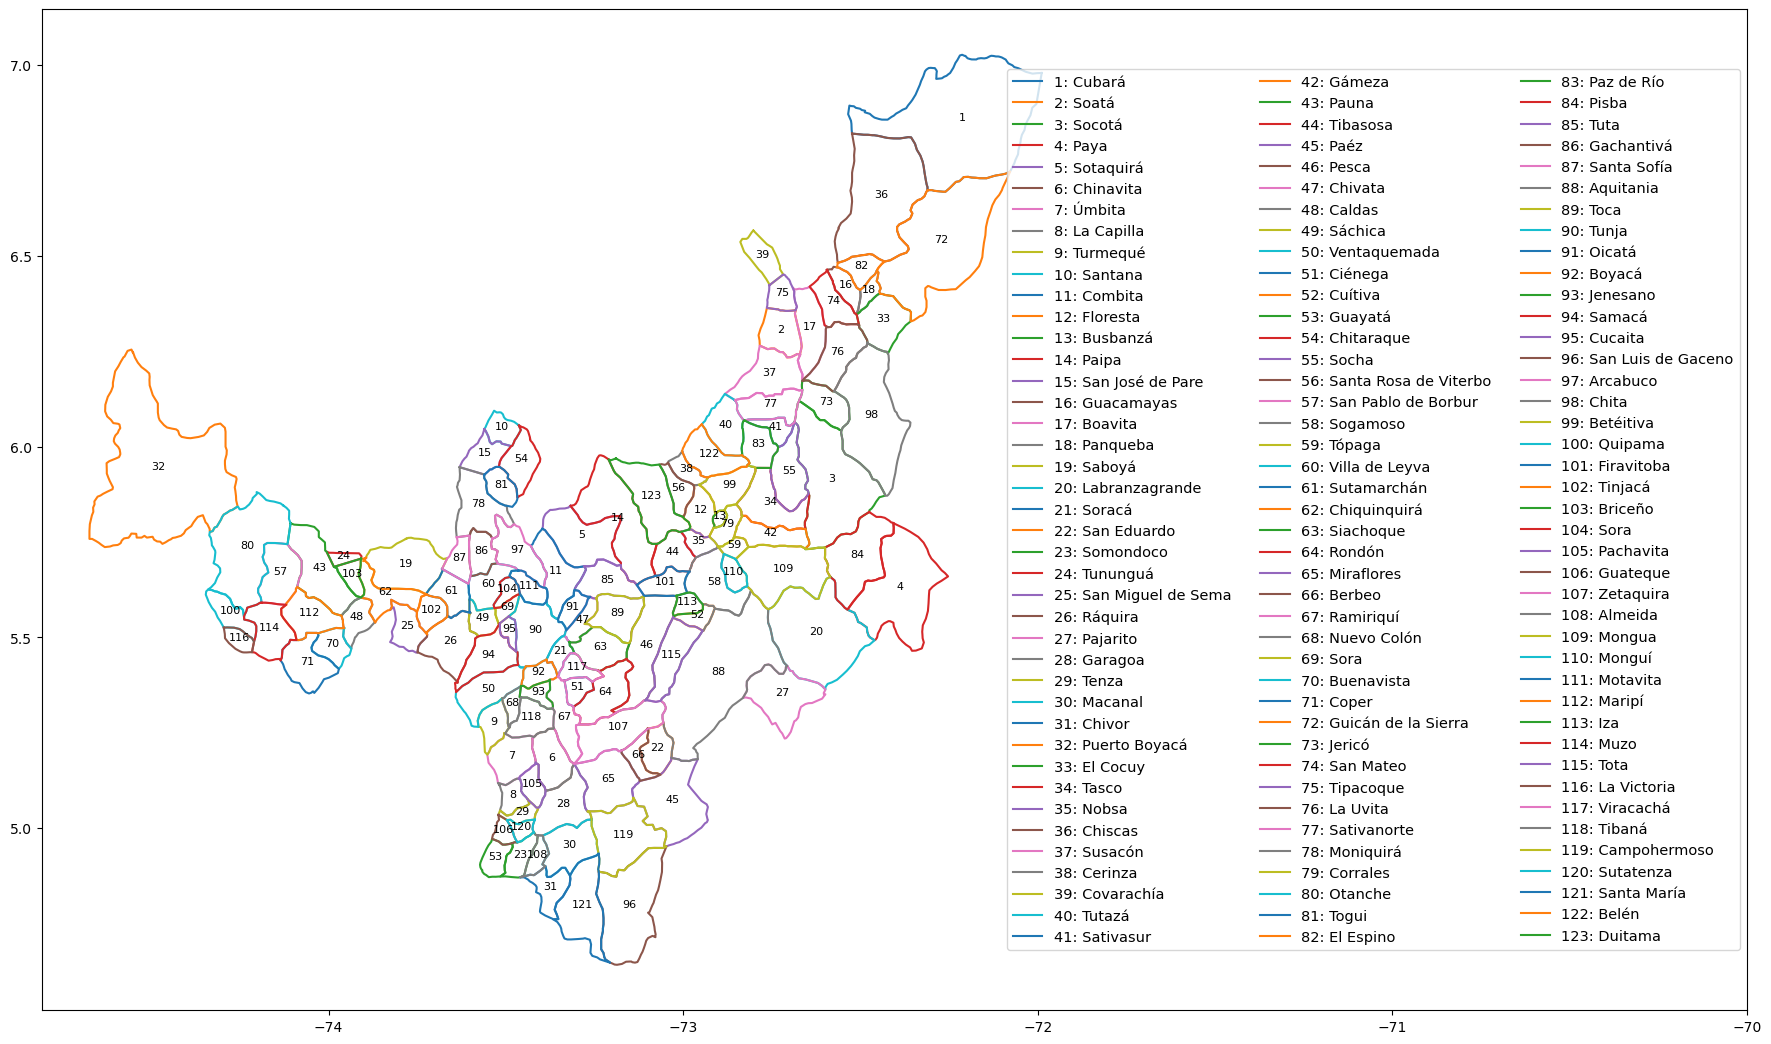

In [11]:
# Grafico con los poligonos ordenados
# Crear una figura y un eje
fig, ax = plt.subplots()
fig.set_size_inches(22, 13)

for i, polygon in enumerate(shape_boyaca_municipios.geometry):
    x, y = polygon.exterior.xy
    ax.plot(x, y)
    centroid = polygon.centroid
    ax.annotate(str(i+1), (centroid.x, centroid.y), textcoords="offset points", xytext=(0,0), ha='center', fontsize=8)

# Etiquetas de leyenda
etiquetas_leyenda = [f"{i+1}: {shape_boyaca_municipios.iloc[i]['municipio']}" for i in range(len(shape_boyaca_municipios))]

# Agregar la leyenda al gráfico
ax.legend(labels=etiquetas_leyenda, fontsize=10.5, ncol=3, loc='center right')
# Agrandar el eje x para que quepa la leyenda
ax.set_xlim(right=-70)

# Mostrar el gráfico
plt.show()


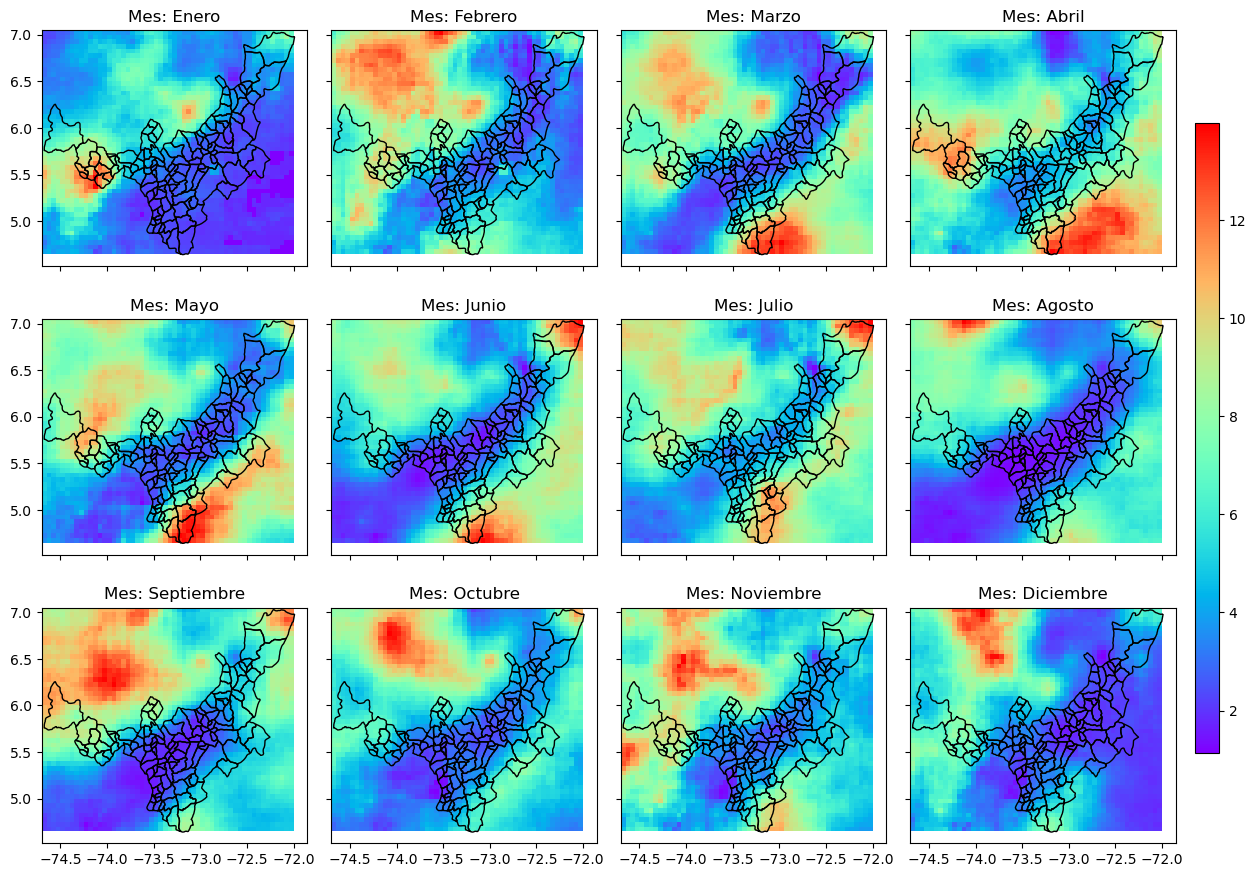

In [12]:
import calendar
import locale

def plot_precipitation_data(precipitation, shape_boyaca_municipios, year):
    # Configurar el idioma local en español
    locale.setlocale(locale.LC_TIME, 'es_ES.UTF-8')

    # Seleccionar un año específico
    pr_year = precipitation.sel(time=str(year))

    # Crear la cuadrícula de subtramas
    fig, axes = plt.subplots(3, 4, figsize=(12, 9), sharex=True, sharey=True)

    # Iterar sobre los meses
    for month, ax in zip(range(1, 13), axes.flat):
        # Seleccionar el mes específico
        pr_month = pr_year.sel(time=slice(f'{year}-{month:02}-01', f'{year}-{month:02}-{calendar.monthrange(year, month)[1]}'))

        # Obtener el nombre del mes en español
        month_name = calendar.month_name[month].capitalize()

        # Calcular el promedio de precipitación para cada punto
        precip_avg = pr_month.mean(dim='time')

        # Convertir a valores normales para el trazado
        x = precip_avg.longitude.values
        y = precip_avg.latitude.values
        xx, yy = np.meshgrid(x, y)

        # Plot del mapa de calor en la subtrama actual
        im = ax.pcolormesh(xx, yy, precip_avg.values, shading='auto', cmap='rainbow')
        shape_boyaca_municipios.plot(ax=ax, color='none', edgecolor='k')
        ax.set_title(f'Mes: {month_name}')

    # Ajustar los espacios entre las subtramas
    plt.tight_layout()

    # Agregar una barra de color común para todos los mapas de calor
    cax = fig.add_axes([1, 0.15, 0.02, 0.7])
    fig.colorbar(im, cax=cax)

    # Mostrar la figura
    plt.show()

# Uso del código
year = 2010
plot_precipitation_data(precipitation, shape_boyaca_municipios, year)


1. Gráfico de Análisis de Tendencias:
   - En este gráfico, se muestra la precipitación promedio a lo largo del tiempo en el área de Boyacá.
   - La línea azul representa el promedio de la precipitación en función del tiempo.
   - La línea roja discontinua indica la tendencia de la precipitación a lo largo del tiempo, calculada mediante una regresión lineal.
   - Si la línea roja tiene una pendiente positiva, indica un aumento en la precipitación a medida que pasa el tiempo, mientras que una pendiente negativa indica una disminución en la precipitación.

2. Gráfico de Anomalías y Variabilidad Interanual:
   - Este gráfico muestra las anomalías de precipitación y la variabilidad interanual en el área de Boyacá.
   - Las anomalías de precipitación se calculan restando el promedio anual de la precipitación de cada año individual.
   - El gráfico muestra la media de estas anomalías a lo largo del tiempo.
   - Los valores positivos indican que la precipitación en un año determinado fue superior al promedio anual, mientras que los valores negativos indican una precipitación por debajo del promedio.

3. Gráfico de Estacionalidad de la Precipitación:
   - Este gráfico representa la estacionalidad de la precipitación en el área de Boyacá.
   - Se calcula el promedio mensual de la precipitación.
   - Cada punto en el gráfico de dispersión representa el promedio mensual de la precipitación en un determinado mes a lo largo del tiempo.
   - Este gráfico nos permite identificar patrones estacionales en la precipitación. Por ejemplo, si hay una concentración de puntos más altos en ciertos meses, indica una estacionalidad marcada en esos meses.




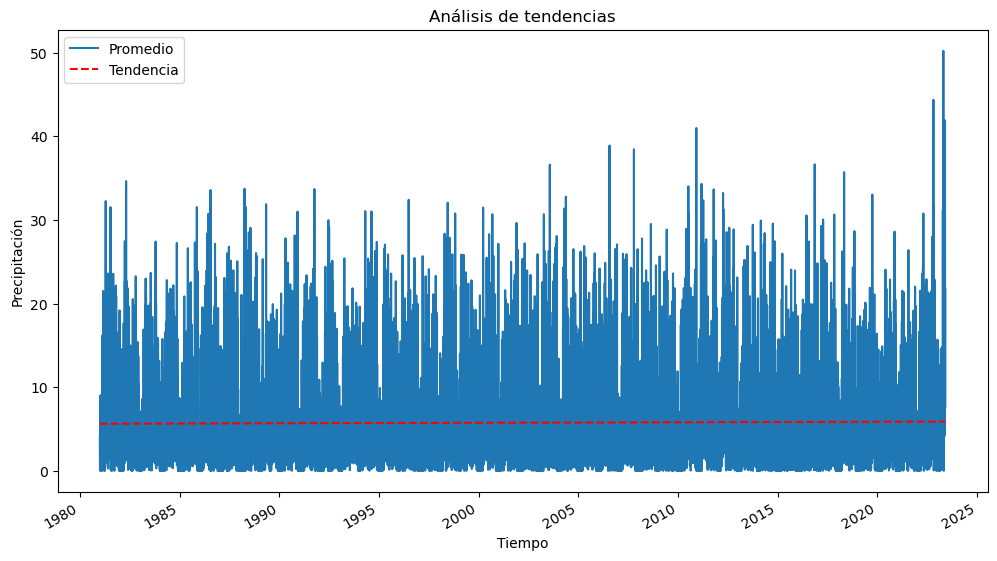

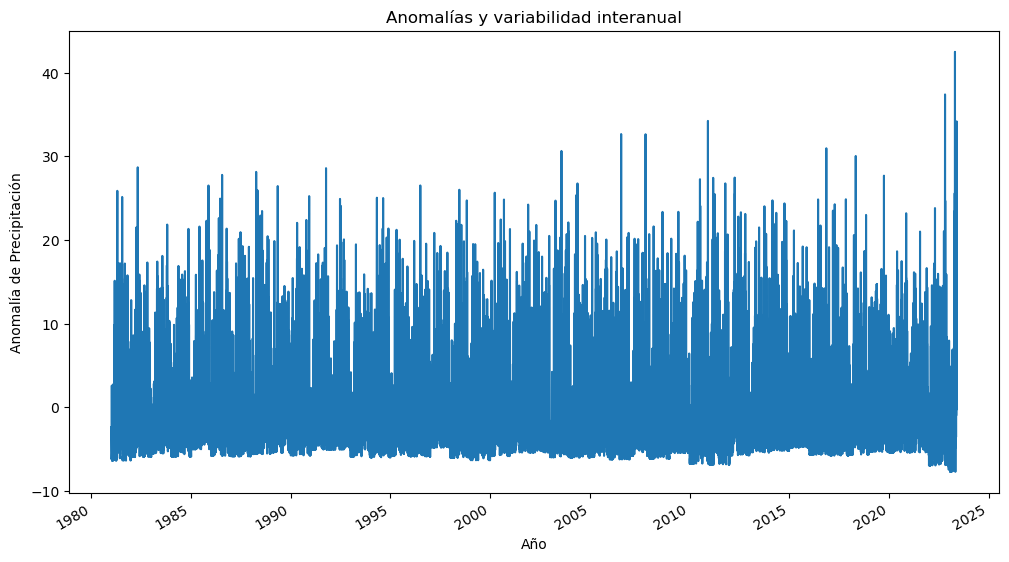

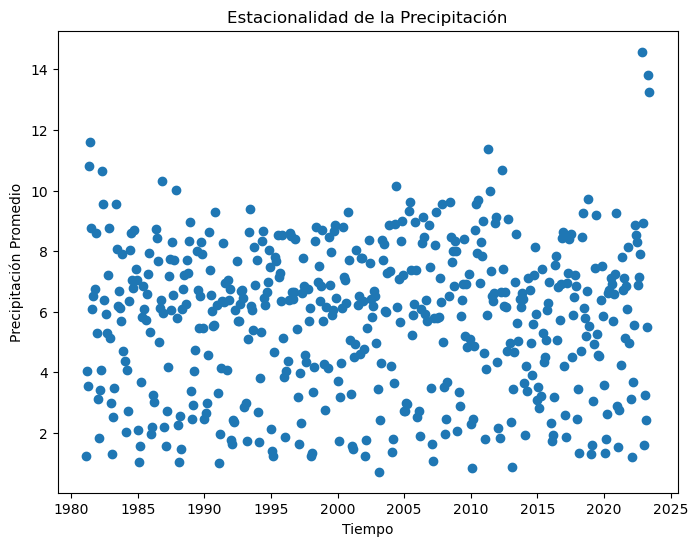

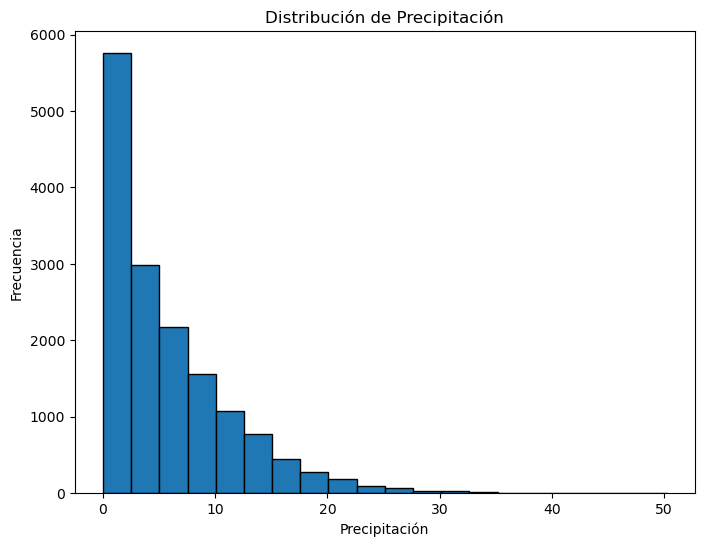

In [13]:
# Convertir las fechas a tipo np.datetime64
data_boyaca['time'] = data_boyaca.time.astype('datetime64[ns]')

# Análisis de tendencias
trends = np.polyfit(data_boyaca.time.values.astype(float), data_boyaca.precip.mean(dim=('latitude', 'longitude')).values, deg=1)
trend_line = np.polyval(trends, data_boyaca.time.values.astype(float))

# Anomalías y variabilidad interanual
annual_mean = data_boyaca.precip.groupby('time.year').mean(dim='time')
anomalies = data_boyaca.precip.groupby('time.year') - annual_mean
anomalies_mean = anomalies.mean(dim=('latitude', 'longitude'))

# Estacionalidad
monthly_mean = data_boyaca.precip.groupby('time.month').mean(dim='time')
seasonal_mean = monthly_mean.mean(dim='month')

# Correlaciones espaciales
correlation = np.corrcoef(data_boyaca.precip.mean(dim='time').values.reshape(-1), rowvar=False)

# Visualización de datos
plt.figure(figsize=(12, 6))
data_boyaca.precip.mean(dim=('latitude', 'longitude')).plot(label='Promedio')
plt.plot(data_boyaca.time, trend_line, 'r--', label='Tendencia')
plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Precipitación')
plt.title('Análisis de tendencias')

plt.figure(figsize=(12, 6))
anomalies_mean.plot()
plt.xlabel('Año')
plt.ylabel('Anomalía de Precipitación')
plt.title('Anomalías y variabilidad interanual')

# Calcular el promedio mensual
monthly_mean = data_boyaca.precip.resample(time='1M').mean()

# Obtener los valores de tiempo y precipitación promedio mensual
time_values = monthly_mean.time.values
precipitation_values = monthly_mean.mean(dim=('latitude', 'longitude')).values

# Gráfico de dispersión con NumPy array
plt.figure(figsize=(8, 6))
plt.scatter(time_values, precipitation_values, marker='o') # type: ignore
plt.xlabel('Tiempo')
plt.ylabel('Precipitación Promedio')
plt.title('Estacionalidad de la Precipitación')

plt.show()

# Calcular el promedio de precipitación en todo el periodo
mean_precipitation = data_boyaca.precip.mean(dim=('latitude', 'longitude'))

# Crear histograma de precipitación
plt.figure(figsize=(8, 6))
plt.hist(mean_precipitation, bins=20, edgecolor='black')
plt.xlabel('Precipitación')
plt.ylabel('Frecuencia')
plt.title('Distribución de Precipitación')
plt.show()


